In [1]:
import NetworkArchitectures as nets
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataset_utils import Format_Dataset
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools

In [2]:
igps_dir = 'data/IGPS/'

# Let's start with IGPS for training and "testing" (really just validation)
features = [
    'BaselineMD', 'BaselineAGIS', 'MD', 'AGIS_score'
]

features = [
    'RNFL_average', 'mean_RNFL_thickness', 'cup_disk_horiz_ratio', 'cup_disk_vert_ratio', 'linear_cup_disc_ratio', 'Age'
]

label_names = [
    'next_ProgressionStructure1'
]

'''features = [
    'IOP', 'HR', 'MAP', 'Qmean', 'P4', 'R4', 'Age'
]'''

# load in IGPS
igps = None
igps_labels = None
maxi, count = len(os.listdir(igps_dir)), 0

for fn in sorted(os.listdir(igps_dir)):
    if fn.endswith('.csv'):
        path = os.path.join(igps_dir, fn)

        if count == 0:
            igps = pd.read_csv(path)[features]  # grab only the features needed
            igps_labels = pd.read_csv(path)[label_names]
            count += 1
            continue

        if count == maxi - 2:
            df = pd.read_csv(path)[features]
            dfl = pd.read_csv(path)[label_names]
        else:
            df = pd.read_csv(path)[features]
            dfl = pd.read_csv(path)[label_names]

        igps = pd.concat([igps, df], axis=1)
        igps_labels = pd.concat([igps_labels, dfl], axis=1)
        count += 1

def impute_col_KNN(df, col_name):
    col = df[[col_name]]
    imputer = KNNImputer(n_neighbors=5)
    col = imputer.fit_transform(col)
    df[col_name] = col

for f in features:
    impute_col_KNN(igps, f)

igps

,RNFL_average,mean_RNFL_thickness,cup_disk_horiz_ratio,cup_disk_vert_ratio,linear_cup_disc_ratio,Age,RNFL_average,mean_RNFL_thickness,cup_disk_horiz_ratio,cup_disk_vert_ratio,...,cup_disk_horiz_ratio,cup_disk_vert_ratio,linear_cup_disc_ratio,Age,RNFL_average,mean_RNFL_thickness,cup_disk_horiz_ratio,cup_disk_vert_ratio,linear_cup_disc_ratio,Age
0,25.31,0.28,0.464,0.490,0.50,68.172485,92.95,0.32,0.565,0.422,...,0.6052,0.4382,0.55,72.016427,95.94,0.32,0.549,0.5156,0.55,72.468172
1,110.12,0.27,0.707,0.598,0.58,68.501027,90.98,0.30,0.900,0.747,...,0.8390,0.6610,0.61,71.986311,101.49,0.30,0.824,0.6670,0.61,72.503765
2,92.80,0.21,0.681,0.794,0.64,58.231348,91.21,0.19,0.885,0.823,...,0.7960,0.6920,0.63,61.741273,77.40,0.13,0.881,0.8940,0.78,62.642026
3,76.84,0.25,0.694,0.637,0.62,75.148528,73.12,0.22,0.849,0.733,...,0.8600,0.7060,0.70,79.321013,94.38,0.21,0.585,0.6190,0.73,79.761807
4,53.00,0.27,0.821,0.705,0.65,71.887748,54.81,0.21,0.859,0.854,...,0.7840,0.8290,0.70,75.512663,49.40,0.39,0.864,0.7410,0.45,75.915127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,62.25,0.16,0.654,0.725,0.32,68.281999,60.57,0.18,0.601,0.734,...,0.6640,0.7640,0.41,71.832991,60.26,0.15,0.652,0.7700,0.43,72.490075
65,75.30,0.10,0.840,0.809,0.75,34.160164,73.88,0.05,0.857,0.819,...,0.7860,0.7190,0.82,38.182067,78.55,0.04,0.790,0.7510,0.82,38.661191
66,53.25,0.21,0.929,0.866,0.55,78.880219,51.62,0.21,0.970,0.818,...,0.8740,0.7960,0.73,82.360027,52.03,0.17,0.734,0.7510,0.58,82.762491
67,65.91,0.16,0.969,0.946,0.73,67.693361,56.82,0.19,0.979,0.860,...,0.9360,0.8760,0.74,71.863107,51.75,0.18,0.948,0.8900,0.74,72.361396


In [3]:
# Let us start with MIMO
n_sequence = 9
n_features = len(features)

# basically the data set is the first 8 visits, and the label set is the last 8 visits: i.e. labels are offset by 1 from the train and since we are doing MIMO there are labels for each time step
igps = igps.to_numpy()
igps_labels = igps_labels.to_numpy()

# normalize data
s = MinMaxScaler()
igps = s.fit_transform(igps)

X = igps
y = igps_labels

X = np.reshape(X, (X.shape[0], n_sequence, n_features))
y = np.reshape(y, (y.shape[0], n_sequence, 1))

train_X, train_y = X[:54], y[:54]
valid_X, valid_y = X[54:63], y[54:63]

print(train_X.shape)
print(train_y.shape)
print(valid_X.shape)
print(valid_y.shape)

dataset = {
    'samples': train_X,
    'labels': train_y
}

# Input layer
train = Format_Dataset(dataset, choice='Train')
train = torch.utils.data.DataLoader(shuffle=False, dataset=train, batch_size=n_sequence)

(54, 9, 6)
(54, 9, 1)
(9, 9, 6)
(9, 9, 1)


In [4]:
params = {
    'n_in': n_features,
    'n_width': 24,
    'n_layers': 1,
    'n_out': 1,
    'mimo': True
}

model = nets.RNN(**params)
loss_fn = nn.BCELoss()
adam = optim.Adam(model.parameters(), lr=0.001)

list(model.parameters())

[Parameter containing:
 tensor([[-0.1454, -0.1796, -0.0065,  0.1393, -0.1335,  0.1874],
         [ 0.1561,  0.0078, -0.1702, -0.0163, -0.0172,  0.1763],
         [ 0.1629,  0.1635, -0.0042,  0.1321, -0.1266,  0.1375],
         [-0.1140,  0.0886, -0.0940,  0.0814,  0.0218, -0.0400],
         [ 0.1481,  0.0243, -0.1289,  0.0118,  0.1707, -0.0679],
         [ 0.1867, -0.1788,  0.1498,  0.0931, -0.1345, -0.0325],
         [ 0.0012, -0.1209,  0.0743,  0.1788,  0.1659, -0.0614],
         [ 0.0976, -0.0628,  0.1156, -0.0558,  0.1404,  0.1025],
         [ 0.1236, -0.1325,  0.0300,  0.0030,  0.0204, -0.0405],
         [-0.1635,  0.1097,  0.1926,  0.1928, -0.1146,  0.1329],
         [-0.1970, -0.1949,  0.0291,  0.1216,  0.0577, -0.0176],
         [-0.0978, -0.0406, -0.1217,  0.0370, -0.1171,  0.0946],
         [ 0.1655,  0.1538,  0.1520,  0.0203,  0.1531,  0.1418],
         [-0.0329,  0.0654, -0.0382, -0.0142, -0.1045,  0.0102],
         [-0.0381, -0.0967,  0.1780,  0.1148, -0.0558,  0.1874],
  

Training... : 100%|██████████| 500/500 [00:04<00:00, 109.17it/s]


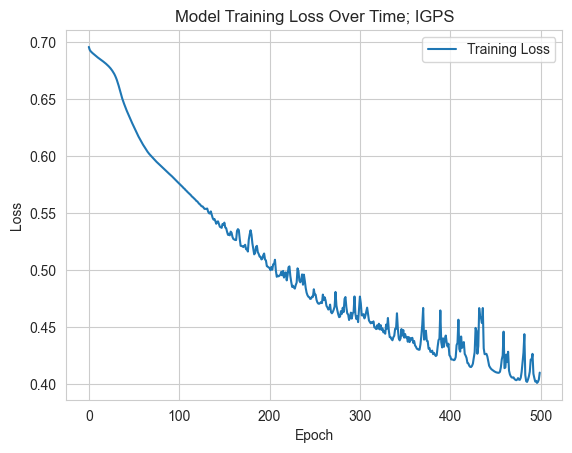

In [5]:
epochs = 500

loss_vals, cross_vals = [], []
for epoch in tqdm(range(epochs), 'Training... '):
    temp_loss = []
    for samples, labels in train:
        samples = samples.float()
        output = model(samples)

        #print(labels.float())
        #print(output)

        loss = loss_fn(output, labels.float())

        adam.zero_grad()
        loss.backward()
        adam.step()

        temp_loss.append(loss.item())

    val = sum(temp_loss[-len(train):]) / len(train)
    loss_vals.append(val)

plt.plot(loss_vals, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training Loss Over Time; IGPS')
plt.legend()
# plt.savefig(results_dir + 'loss.png', dpi=900)
plt.show()

In [6]:
model.eval()

valid_X = valid_X
valid_X = valid_X.astype('float32')
with torch.no_grad():
    print(valid_X.shape)
    out = model(torch.tensor(valid_X)).detach().numpy()

preds = (torch.from_numpy(out) > 0.5).float()

truth = valid_y.tolist()
preds = preds.tolist()

truth = list(itertools.chain.from_iterable(truth))
preds = list(itertools.chain.from_iterable(preds))

print(truth)

(9, 9, 6)
[[0], [0], [1], [0], [1], [1], [1], [1], [0], [1], [1], [0], [1], [0], [1], [0], [0], [0], [0], [1], [1], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [1], [1], [1], [0], [0], [1], [0], [1], [1], [1], [1], [0], [1], [1], [1], [1], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [1], [0], [1], [1], [0], [0], [1]]


Accuracy Score: 0.5061728395061729
Precision Score: 0.43333333333333335
Recall Score: 0.8125
F1 Score:  0.5652173913043479


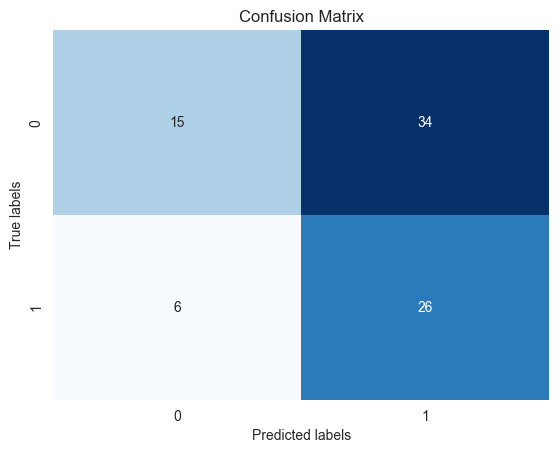

In [7]:
cm = confusion_matrix(truth, preds)

accuracy = accuracy_score(truth, preds)
print("Accuracy Score:", accuracy)

precision = precision_score(truth, preds)
print("Precision Score:", precision)

recall = recall_score(truth, preds)
print("Recall Score:", recall)

f1 = f1_score(truth, preds)
print("F1 Score: ", f1)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('results/RNN_MIMO/base_struc_cm.png', dpi=900)
plt.show()

In [8]:
# grid search ;)
best_acc, best_prec, best_rec, best_f1, sum = 0, 0, 0, 0, 0
best_cm, best_model, best_params = None, None, None
for l in range(1, 5):
    for w in range(1, 101, 2):
        print(l)
        print(w)

        params = {
            'n_in': n_features,
            'n_width': w,
            'n_layers': l,
            'n_out': 1,
            'mimo': True
        }

        model = nets.RNN(**params)
        loss_fn = nn.BCELoss()
        adam = optim.Adam(model.parameters(), lr=0.001)

        epochs = 500
        loss_vals, cross_vals = [], []
        for epoch in tqdm(range(epochs), 'Training... '):
            temp_loss = []
            for samples, labels in train:
                samples = samples.float()
                output = model(samples)

                loss = loss_fn(output, labels.float())

                adam.zero_grad()
                loss.backward()
                adam.step()

                temp_loss.append(loss.item())

        model.eval()

        X = valid_X
        X = X.astype('float32')
        with torch.no_grad():
            out = model(torch.tensor(X)).detach().numpy()

        preds = (torch.from_numpy(out) > 0.5).float()

        truth = valid_y.tolist()
        preds = preds.tolist()

        truth = list(itertools.chain.from_iterable(truth))
        preds = list(itertools.chain.from_iterable(preds))

        print(preds)

        cm = confusion_matrix(truth, preds)
        accuracy = accuracy_score(truth, preds)
        precision = precision_score(truth, preds)
        recall = recall_score(truth, preds)
        f1 = f1_score(truth, preds)

        curr = (f1 + accuracy)/2
        print("F1 + Acc: ", curr)

        if curr > sum:
            best_cm = cm
            best_acc = accuracy
            best_prec = precision
            best_rec = recall
            best_f1 = f1
            best_model = model
            best_params = params
            sum = curr

1
1


Training... : 100%|██████████| 500/500 [00:04<00:00, 114.06it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.6379713046379714
1
3


Training... : 100%|██████████| 500/500 [00:03<00:00, 125.48it/s]


[[0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.6121121121121121
1
5


Training... : 100%|██████████| 500/500 [00:05<00:00, 99.75it/s] 


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5924490381854723
1
7


Training... : 100%|██████████| 500/500 [00:04<00:00, 119.07it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4601023788015658
1
9


Training... : 100%|██████████| 500/500 [00:03<00:00, 139.54it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0]]
F1 + Acc:  0.5249382716049382
1
11


Training... : 100%|██████████| 500/500 [00:03<00:00, 139.27it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4929948675267027
1
13


Training... : 100%|██████████| 500/500 [00:03<00:00, 129.06it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5279320987654321
1
15


Training... : 100%|██████████| 500/500 [00:04<00:00, 114.04it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0]]
F1 + Acc:  0.43340595497458245
1
17


Training... : 100%|██████████| 500/500 [00:04<00:00, 123.72it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.41358024691358025
1
19


Training... : 100%|██████████| 500/500 [00:05<00:00, 98.02it/s] 


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.44981213097155126
1
21


Training... : 100%|██████████| 500/500 [00:03<00:00, 126.99it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5566778900112233
1
23


Training... : 100%|██████████| 500/500 [00:04<00:00, 121.69it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.454685746352413
1
25


Training... : 100%|██████████| 500/500 [00:03<00:00, 129.41it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4735802469135802
1
27


Training... : 100%|██████████| 500/500 [00:03<00:00, 131.25it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4479012345679012
1
29


Training... : 100%|██████████| 500/500 [00:03<00:00, 137.31it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4340900039824771
1
31


Training... : 100%|██████████| 500/500 [00:03<00:00, 135.27it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0]]
F1 + Acc:  0.4601023788015658
1
33


Training... : 100%|██████████| 500/500 [00:03<00:00, 137.82it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5432098765432098
1
35


Training... : 100%|██████████| 500/500 [00:03<00:00, 146.27it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5124238162212846
1
37


Training... : 100%|██████████| 500/500 [00:02<00:00, 176.96it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5086753420086754
1
39


Training... : 100%|██████████| 500/500 [00:02<00:00, 176.89it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4775533108866442
1
41


Training... : 100%|██████████| 500/500 [00:03<00:00, 163.92it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.345679012345679
1
43


Training... : 100%|██████████| 500/500 [00:03<00:00, 155.41it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0]]
F1 + Acc:  0.49382716049382713
1
45


Training... : 100%|██████████| 500/500 [00:03<00:00, 161.67it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0]]
F1 + Acc:  0.40532081377151796
1
47


Training... : 100%|██████████| 500/500 [00:03<00:00, 133.19it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4225589225589225
1
49


Training... : 100%|██████████| 500/500 [00:03<00:00, 146.34it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.43741209563994377
1
51


Training... : 100%|██████████| 500/500 [00:03<00:00, 152.51it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5277777777777778
1
53


Training... : 100%|██████████| 500/500 [00:03<00:00, 138.76it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.47665056360708535
1
55


Training... : 100%|██████████| 500/500 [00:03<00:00, 136.80it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4124081887794968
1
57


Training... : 100%|██████████| 500/500 [00:03<00:00, 137.19it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.38355780022446695
1
59


Training... : 100%|██████████| 500/500 [00:03<00:00, 155.75it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.35667438271604934
1
61


Training... : 100%|██████████| 500/500 [00:03<00:00, 133.08it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4553471220137887
1
63


Training... : 100%|██████████| 500/500 [00:03<00:00, 153.63it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5979107312440646
1
65


Training... : 100%|██████████| 500/500 [00:03<00:00, 161.27it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4575163398692811
1
67


Training... : 100%|██████████| 500/500 [00:03<00:00, 162.38it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.38210888484112526
1
69


Training... : 100%|██████████| 500/500 [00:03<00:00, 134.51it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.48741990936083757
1
71


Training... : 100%|██████████| 500/500 [00:03<00:00, 160.33it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0]]
F1 + Acc:  0.5227565874332043
1
73


Training... : 100%|██████████| 500/500 [00:03<00:00, 161.70it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.46241600250039067
1
75


Training... : 100%|██████████| 500/500 [00:03<00:00, 160.71it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5034889962426194
1
77


Training... : 100%|██████████| 500/500 [00:03<00:00, 154.12it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5919428200129955
1
79


Training... : 100%|██████████| 500/500 [00:03<00:00, 139.08it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.413417803768681
1
81


Training... : 100%|██████████| 500/500 [00:04<00:00, 120.27it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5279320987654321
1
83


Training... : 100%|██████████| 500/500 [00:04<00:00, 122.81it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5908289241622575
1
85


Training... : 100%|██████████| 500/500 [00:03<00:00, 138.26it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.41975308641975306
1
87


Training... : 100%|██████████| 500/500 [00:03<00:00, 126.95it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0]]
F1 + Acc:  0.36241065627030544
1
89


Training... : 100%|██████████| 500/500 [00:03<00:00, 134.56it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.3793793793793794
1
91


Training... : 100%|██████████| 500/500 [00:03<00:00, 133.78it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.46737213403880074
1
93


Training... : 100%|██████████| 500/500 [00:03<00:00, 125.77it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4400473532893624
1
95


Training... : 100%|██████████| 500/500 [00:03<00:00, 141.19it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.38543209876543216
1
97


Training... : 100%|██████████| 500/500 [00:03<00:00, 146.30it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0]]
F1 + Acc:  0.39654320987654323
1
99


Training... : 100%|██████████| 500/500 [00:03<00:00, 142.77it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.49925925925925924
2
1


Training... : 100%|██████████| 500/500 [00:04<00:00, 109.49it/s]


[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.48071670490549545
2
3


Training... : 100%|██████████| 500/500 [00:04<00:00, 110.40it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.43892137751786875
2
5


Training... : 100%|██████████| 500/500 [00:04<00:00, 119.59it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0]]
F1 + Acc:  0.5684754521963824
2
7


Training... : 100%|██████████| 500/500 [00:04<00:00, 110.26it/s]


[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4929948675267027
2
9


Training... : 100%|██████████| 500/500 [00:04<00:00, 105.02it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4222222222222223
2
11


Training... : 100%|██████████| 500/500 [00:04<00:00, 106.61it/s]


[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.49925925925925924
2
13


Training... : 100%|██████████| 500/500 [00:05<00:00, 93.01it/s] 


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5130718954248366
2
15


Training... : 100%|██████████| 500/500 [00:04<00:00, 107.20it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.3535623977391046
2
17


Training... : 100%|██████████| 500/500 [00:04<00:00, 103.57it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5205282802182027
2
19


Training... : 100%|██████████| 500/500 [00:04<00:00, 106.20it/s]


[[1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5030864197530864
2
21


Training... : 100%|██████████| 500/500 [00:04<00:00, 113.60it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5205282802182027
2
23


Training... : 100%|██████████| 500/500 [00:04<00:00, 104.86it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4806798140131473
2
25


Training... : 100%|██████████| 500/500 [00:04<00:00, 108.55it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5603937270603937
2
27


Training... : 100%|██████████| 500/500 [00:04<00:00, 114.16it/s]


[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.369296833064949
2
29


Training... : 100%|██████████| 500/500 [00:04<00:00, 114.80it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.273169883498522
2
31


Training... : 100%|██████████| 500/500 [00:04<00:00, 113.72it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.32603025560772037
2
33


Training... : 100%|██████████| 500/500 [00:04<00:00, 114.08it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.3205128205128205
2
35


Training... : 100%|██████████| 500/500 [00:04<00:00, 113.20it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.43892137751786875
2
37


Training... : 100%|██████████| 500/500 [00:04<00:00, 113.41it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.49667616334283
2
39


Training... : 100%|██████████| 500/500 [00:05<00:00, 86.23it/s] 


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.49213597158802636
2
41


Training... : 100%|██████████| 500/500 [00:04<00:00, 103.65it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.42297369833601717
2
43


Training... : 100%|██████████| 500/500 [00:04<00:00, 109.71it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.3286836620169954
2
45


Training... : 100%|██████████| 500/500 [00:04<00:00, 109.14it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.3708452041785375
2
47


Training... : 100%|██████████| 500/500 [00:04<00:00, 108.76it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5086753420086754
2
49


Training... : 100%|██████████| 500/500 [00:04<00:00, 109.62it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.35352018685352016
2
51


Training... : 100%|██████████| 500/500 [00:06<00:00, 79.13it/s] 


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0]]
F1 + Acc:  0.5540123456790124
2
53


Training... : 100%|██████████| 500/500 [00:07<00:00, 62.83it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4735802469135802
2
55


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.97it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4644249512670565
2
57


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.77it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.42151675485008816
2
59


Training... : 100%|██████████| 500/500 [00:07<00:00, 64.53it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4458315993896518
2
61


Training... : 100%|██████████| 500/500 [00:08<00:00, 60.77it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.48741990936083757
2
63


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.09it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.5147198480531814
2
65


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.39it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5218423551756886
2
67


Training... : 100%|██████████| 500/500 [00:06<00:00, 73.50it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5015432098765432
2
69


Training... : 100%|██████████| 500/500 [00:06<00:00, 73.73it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0]]
F1 + Acc:  0.49213597158802636
2
71


Training... : 100%|██████████| 500/500 [00:06<00:00, 71.65it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0]]
F1 + Acc:  0.48741990936083757
2
73


Training... : 100%|██████████| 500/500 [00:07<00:00, 68.06it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4317509998261172
2
75


Training... : 100%|██████████| 500/500 [00:08<00:00, 56.29it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4317509998261172
2
77


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.49it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5472663139329805
2
79


Training... : 100%|██████████| 500/500 [00:08<00:00, 59.72it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.48602033405954975
2
81


Training... : 100%|██████████| 500/500 [00:08<00:00, 59.47it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.6045697438732265
2
83


Training... : 100%|██████████| 500/500 [00:08<00:00, 59.71it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0]]
F1 + Acc:  0.5345345345345345
2
85


Training... : 100%|██████████| 500/500 [00:08<00:00, 58.31it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.49213597158802636
2
87


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.74it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5110415579899148
2
89


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.86it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5110415579899148
2
91


Training... : 100%|██████████| 500/500 [00:09<00:00, 55.11it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5571658615136876
2
93


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.08it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5086753420086754
2
95


Training... : 100%|██████████| 500/500 [00:09<00:00, 51.89it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.47150997150997154
2
97


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.97it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.47530864197530864
2
99


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.67it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.396011396011396
3
1


Training... : 100%|██████████| 500/500 [00:06<00:00, 72.13it/s]


[[0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.6374433505235193
3
3


Training... : 100%|██████████| 500/500 [00:07<00:00, 69.47it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4537037037037037
3
5


Training... : 100%|██████████| 500/500 [00:06<00:00, 82.62it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.43162393162393164
3
7


Training... : 100%|██████████| 500/500 [00:05<00:00, 89.00it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5110415579899148
3
9


Training... : 100%|██████████| 500/500 [00:06<00:00, 79.96it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.48741990936083757
3
11


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.15it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0]]
F1 + Acc:  0.5021043771043772
3
13


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.49it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0]]
F1 + Acc:  0.5124238162212846
3
15


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.44it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5571658615136876
3
17


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.41it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5303274288781535
3
19


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.03it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4601023788015658
3
21


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.87it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0]]
F1 + Acc:  0.40523857190523854
3
23


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.72it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.47824074074074074
3
25


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.23it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0]]
F1 + Acc:  0.37934904601571273
3
27


Training... : 100%|██████████| 500/500 [00:08<00:00, 60.80it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5277777777777778
3
29


Training... : 100%|██████████| 500/500 [00:06<00:00, 76.23it/s]


[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5030864197530864
3
31


Training... : 100%|██████████| 500/500 [00:06<00:00, 77.04it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5862529195862529
3
33


Training... : 100%|██████████| 500/500 [00:06<00:00, 83.31it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0]]
F1 + Acc:  0.49382716049382713
3
35


Training... : 100%|██████████| 500/500 [00:06<00:00, 73.04it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4400473532893624
3
37


Training... : 100%|██████████| 500/500 [00:06<00:00, 81.60it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.44981213097155126
3
39


Training... : 100%|██████████| 500/500 [00:06<00:00, 75.46it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5147198480531814
3
41


Training... : 100%|██████████| 500/500 [00:06<00:00, 81.66it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4644249512670565
3
43


Training... : 100%|██████████| 500/500 [00:06<00:00, 81.99it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5571658615136876
3
45


Training... : 100%|██████████| 500/500 [00:06<00:00, 80.40it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.45005611672278345
3
47


Training... : 100%|██████████| 500/500 [00:06<00:00, 80.66it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5298474945533769
3
49


Training... : 100%|██████████| 500/500 [00:06<00:00, 80.01it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5664392462638077
3
51


Training... : 100%|██████████| 500/500 [00:06<00:00, 78.67it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.43741209563994377
3
53


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.62it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5442245898866903
3
55


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.70it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5218423551756886
3
57


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.18it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5249382716049382
3
59


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.18it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5571658615136876
3
61


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.13it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.37934904601571273
3
63


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.38it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4999256284396847
3
65


Training... : 100%|██████████| 500/500 [00:10<00:00, 48.80it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0]]
F1 + Acc:  0.4222222222222223
3
67


Training... : 100%|██████████| 500/500 [00:10<00:00, 47.62it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4211775878442545
3
69


Training... : 100%|██████████| 500/500 [00:10<00:00, 46.99it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4940035273368607
3
71


Training... : 100%|██████████| 500/500 [00:10<00:00, 46.79it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.5015432098765432
3
73


Training... : 100%|██████████| 500/500 [00:10<00:00, 46.52it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5701804368471035
3
75


Training... : 100%|██████████| 500/500 [00:11<00:00, 45.29it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0]]
F1 + Acc:  0.5571658615136876
3
77


Training... : 100%|██████████| 500/500 [00:12<00:00, 41.62it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.5110415579899148
3
79


Training... : 100%|██████████| 500/500 [00:11<00:00, 43.18it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0]]
F1 + Acc:  0.4644249512670565
3
81


Training... : 100%|██████████| 500/500 [00:11<00:00, 43.41it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.5206349206349207
3
83


Training... : 100%|██████████| 500/500 [00:11<00:00, 45.12it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4225589225589225
3
85


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.56it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5721747388414056
3
87


Training... : 100%|██████████| 500/500 [00:10<00:00, 48.43it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5206349206349207
3
89


Training... : 100%|██████████| 500/500 [00:09<00:00, 55.47it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4581811858807164
3
91


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.86it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4400473532893624
3
93


Training... : 100%|██████████| 500/500 [00:09<00:00, 51.74it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4965277777777778
3
95


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.38it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0]]
F1 + Acc:  0.506012506012506
3
97


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.35it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.47530864197530864
3
99


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.88it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5762962962962963
4
1


Training... : 100%|██████████| 500/500 [00:07<00:00, 69.54it/s]


[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.48071670490549545
4
3


Training... : 100%|██████████| 500/500 [00:07<00:00, 68.50it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4509734093067427
4
5


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.64it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4537037037037037
4
7


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.62it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.43741209563994377
4
9


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.08it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5181802807373583
4
11


Training... : 100%|██████████| 500/500 [00:08<00:00, 62.02it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.3950617283950617
4
13


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.58it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5050505050505051
4
15


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.24it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4783950617283951
4
17


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.52it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.4940035273368607
4
19


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.46it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4660916624386944
4
21


Training... : 100%|██████████| 500/500 [00:07<00:00, 66.46it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.38791423001949316
4
23


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.12it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.5154320987654322
4
25


Training... : 100%|██████████| 500/500 [00:07<00:00, 67.18it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0]]
F1 + Acc:  0.4954855352865303
4
27


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.39it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4317509998261172
4
29


Training... : 100%|██████████| 500/500 [00:07<00:00, 65.96it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.4660916624386944
4
31


Training... : 100%|██████████| 500/500 [00:07<00:00, 63.54it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.43741209563994377
4
33


Training... : 100%|██████████| 500/500 [00:08<00:00, 62.47it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4444444444444444
4
35


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.67it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.45339506172839505
4
37


Training... : 100%|██████████| 500/500 [00:07<00:00, 64.96it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5963132081853543
4
39


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.14it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.4660916624386944
4
41


Training... : 100%|██████████| 500/500 [00:07<00:00, 62.81it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.3358701166920345
4
43


Training... : 100%|██████████| 500/500 [00:08<00:00, 60.82it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.46737213403880074
4
45


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.34it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.42224996532112635
4
47


Training... : 100%|██████████| 500/500 [00:08<00:00, 61.25it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.45005611672278345
4
49


Training... : 100%|██████████| 500/500 [00:08<00:00, 58.58it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4589804858622063
4
51


Training... : 100%|██████████| 500/500 [00:08<00:00, 57.37it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.43892137751786875
4
53


Training... : 100%|██████████| 500/500 [00:08<00:00, 58.71it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.49925925925925924
4
55


Training... : 100%|██████████| 500/500 [00:09<00:00, 55.16it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0]]
F1 + Acc:  0.3114035087719298
4
57


Training... : 100%|██████████| 500/500 [00:08<00:00, 56.58it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4315289648622982
4
59


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.96it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.44907407407407407
4
61


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.54it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5154320987654322
4
63


Training... : 100%|██████████| 500/500 [00:09<00:00, 54.50it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5166352793471437
4
65


Training... : 100%|██████████| 500/500 [00:08<00:00, 55.72it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4940035273368607
4
67


Training... : 100%|██████████| 500/500 [00:09<00:00, 53.80it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.44981213097155126
4
69


Training... : 100%|██████████| 500/500 [00:09<00:00, 52.95it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.3708641975308642
4
71


Training... : 100%|██████████| 500/500 [00:10<00:00, 49.53it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.413417803768681
4
73


Training... : 100%|██████████| 500/500 [00:11<00:00, 45.23it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5057371096586782
4
75


Training... : 100%|██████████| 500/500 [00:10<00:00, 46.32it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.48602033405954975
4
77


Training... : 100%|██████████| 500/500 [00:09<00:00, 50.63it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.46737213403880074
4
79


Training... : 100%|██████████| 500/500 [00:14<00:00, 34.56it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0]]
F1 + Acc:  0.4806798140131473
4
81


Training... : 100%|██████████| 500/500 [00:13<00:00, 37.68it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.49213597158802636
4
83


Training... : 100%|██████████| 500/500 [00:13<00:00, 36.17it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.35076252723311546
4
85


Training... : 100%|██████████| 500/500 [00:13<00:00, 35.98it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.5472663139329805
4
87


Training... : 100%|██████████| 500/500 [00:13<00:00, 36.09it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4660916624386944
4
89


Training... : 100%|██████████| 500/500 [00:10<00:00, 45.94it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.5409356725146199
4
91


Training... : 100%|██████████| 500/500 [00:11<00:00, 44.17it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.4660916624386944
4
93


Training... : 100%|██████████| 500/500 [00:11<00:00, 42.30it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0]]
F1 + Acc:  0.49667616334283
4
95


Training... : 100%|██████████| 500/500 [00:11<00:00, 41.85it/s]


[[1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0], [1.0], [1.0], [0.0], [0.0]]
F1 + Acc:  0.43001443001442996
4
97


Training... : 100%|██████████| 500/500 [00:12<00:00, 38.84it/s]


[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0]]
F1 + Acc:  0.5874355368026254
4
99


Training... : 100%|██████████| 500/500 [00:12<00:00, 39.07it/s]

[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [1.0], [0.0], [1.0], [1.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [1.0], [0.0], [1.0], [0.0]]
F1 + Acc:  0.4899285250162443


Accuracy Score: 0.654320987654321
Precision Score: 0.5476190476190477
Recall Score: 0.71875
F1 Score:  0.6216216216216217
Best Parameters:
{'n_in': 6, 'n_width': 1, 'n_layers': 1, 'n_out': 1, 'mimo': True}


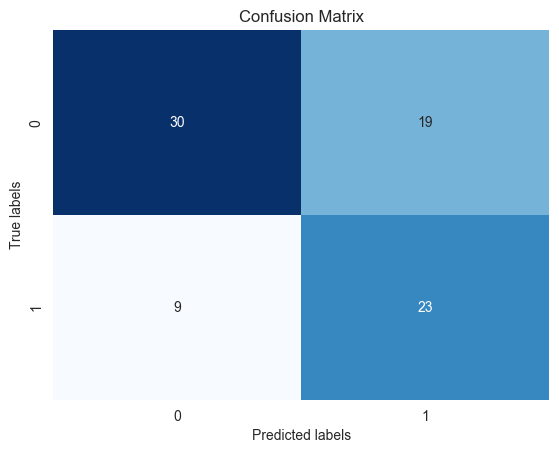

In [9]:
print("Accuracy Score:", best_acc)
print("Precision Score:", best_prec)
print("Recall Score:", best_rec)
print("F1 Score: ", best_f1)

print("Best Parameters:")
print(best_params)

sns.heatmap(best_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('results/RNN_MIMO/grid_struc_cm.png', dpi=900)
plt.show()